<a href="https://colab.research.google.com/github/szucshey/osm-data-exploration/blob/main/climate/climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install folium osm2geojson geopandas regionmask --quiet

In [4]:
import folium
import requests
import json
import osm2geojson
import geopandas as gpd
import matplotlib.pyplot as plt
from netCDF4 import Dataset

In [5]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
    [out:json];
    rel["ISO3166-1"~"^HU"]
    [admin_level=2]
    [type=boundary]
    [boundary=administrative];
    out geom;
    """

response = requests.get(overpass_url, params={'data': overpass_query})

#Az API válasz lementése egy json fileba
output = open("geojson.json", "w")
json.dump(response.json(), output)
output.close()

In [6]:
data = json.load(open("geojson.json", "r"))
geojson = osm2geojson.json2geojson(data)

#m = folium.Map(location=[47.161, 19.505], zoom_start=8, min_zoom=7, maxBounds=[[40.000, 10.000], [60.000, 30.000]], tiles=None, attr="", prefer_canvas=True, overlay=True)
#m.add_child(folium.GeoJson(geojson, name='geojson'))

#m

In [7]:
gdf = gpd.GeoDataFrame.from_features(geojson)

In [71]:
import xarray as xr
import regionmask
import numpy as np

#lon = np.arange(15, 24)
#lat = np.arange(45, 50)

#mask = regionmask.mask_geopandas(gdf, lon, lat)
ds = xr.open_dataarray("drive/MyDrive/climate/rr_ens_mean_0.1deg_reg_1950-1964_v25.0e.nc")
ds = ds.sel(time=ds['time'], longitude=slice(15.96, 23.12), latitude=slice(45.55, 48.73))
ds.to_netcdf("test2.nc")

mask = regionmask.Regions(gdf['geometry'])
mask = mask.mask(ds, lat_name = 'latitude', lon_name = 'longitude')
#mask1
#mask.to_netcdf("teszt.nc")

masked_nc = xr.open_dataarray("teszt.nc")


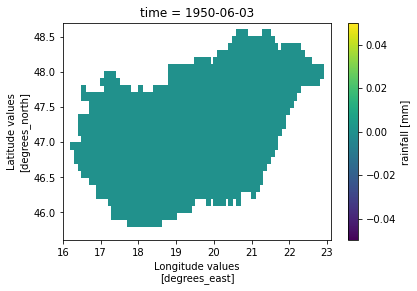

In [9]:
#ds = xr.open_dataarray("rr_ens_mean_0.1deg_reg_1950-1964_v25.0e.nc")
shape = ds.where(masked_nc == 0)
shape.to_netcdf("test2.nc")
shape[153, :, :].plot()
#ds.isel(time = 160).plot(xlim=[-25,43], ylim=[30,72])
#ds[5478, :, :].plot()

In [98]:
import PIL
from datetime import datetime, timedelta, date

In [37]:
for i in range(10):
  plt.show(shape[i, :, :])
  #plot.savefig("drive/MyDrive/climate/test_output/{0}.jpg".format(str(i)))

ValueError: ignored

In [18]:
dates = ds.dims[0][:]
dates

'time'

In [19]:
pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
ds_test = Dataset("test2.nc")

lats = ds_test.variables['latitude'][:]
lons = ds_test.variables['longitude'][:]
dates = ds_test.variables['time'][:]
rain = ds_test.variables['rr'][:]

lon, lat = np.meshgrid(lons, lats)

plt.show()


In [16]:
pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 864 kB 8.3 MB/s 
     |████████████████████████████████| 30.5 MB 1.4 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 


In [18]:
from mpl_toolkits.basemap import Basemap

In [112]:
#longitude=slice(15.96, 23.12), latitude=slice(45.55, 48.73))
start_date = date(1950, 1, 1)

for i in range(365):
  end_date = start_date + timedelta(days=i)
  y, m, d = end_date.strftime("%Y"), end_date.strftime("%m"), end_date.strftime("%d")
  end_date_str = y + "-" + m + "-" + d

  map = Basemap(llcrnrlon=16.06, llcrnrlat=45.65, urcrnrlon=23.02, urcrnrlat=48.63, projection='merc', resolution='i')

  x,y = map(lon, lat)
  map.drawcountries()

  plt.title("Csapadék mennyiség: {0}".format(end_date_str))

  color_scheme = map.pcolor(x,y, np.squeeze(rain[i, :, :]), cmap='BuPu')
  color_bar = map.colorbar(color_scheme, location='right', pad='5%')
  color_bar.set_label('Csapadék mennyisége (mm)', labelpad=5)
  plt.clim(0, 80)
  plt.savefig("drive/MyDrive/climate/test_output/{0}.jpg".format(i+1), dpi=300)
  plt.clf()


<Figure size 432x288 with 0 Axes>

In [100]:

end_date = start_date + timedelta(days=10)

y, m, d = end_date.strftime("%Y"), end_date.strftime("%m"), end_date.strftime("%d")

end_date_str = y + "-" + m + "-" + d
end_date_str

'1950-01-11'

In [115]:
frames = []

for i in range(365):
  frame = PIL.Image.open("drive/MyDrive/climate/test_output/{0}.jpg".format(str(i+1)))
  frames.append(frame)

frames[0].save('drive/MyDrive/climate/test_output/test.gif', 
               format='GIF',
               append_images = frames[1: ], 
               save_all = True,
               duration=60, loop=0)